In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import mlflow_utils
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score, f1_score





In [5]:
data = pd.read_csv("hand_landmarks_data.csv")

print(data.shape)
print(data.columns[:10])
data.isnull().sum().sort_values(ascending=False).head()

# no null values , no missing columns , 63 feature (21 point each has x,y,z ) and 1 label

(25675, 64)
Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4'], dtype='object')


x1    0
y1    0
z1    0
x2    0
y2    0
dtype: int64

In [6]:
# renaming columns to a more readable format start form 0 index

new_columns = []
for i in range(21):
    new_columns.extend([f'x{i}', f'y{i}', f'z{i}'])
new_columns.append('label') 

data.columns = new_columns

In [7]:
# recentring the coordinates to the make the wrist is the origin (x0, y0, z0)

wrist_old = data[['x0', 'y0', 'z0']]
wrist_old.head()

for i in range(21):

    data[f'x{i}'] = data[f'x{i}'] - wrist_old['x0']
    data[f'y{i}'] = data[f'y{i}'] - wrist_old['y0']

    # like the Project Description said, we will ignore the Z coordinate for now

    #data[f'z{i}'] = data[f'z{i}'] - wrist_old['z0']
    

In [8]:
# normalizing the Data by dividing all the coordinates by the distance between the wrist and the middle finger tip (landmark 12)

data['distance'] = np.sqrt(data['x12']**2 + data['y12']**2 )
data['distance'] = data['distance'].replace(0, 1)

for i in range(21):

    data[f'x{i}'] = data[f'x{i}'] / data['distance']
    data[f'y{i}'] = data[f'y{i}'] / data['distance']

    # like the Project Description said, we will ignore the Z coordinate for now

    #data[f'z{i}'] = data[f'z{i}'] / data['distance']

data.drop(columns=['distance'], inplace=True)

In [9]:
# feature engineering : calculating the angle between each finger and the next one , 
# and the angle of the joint to help in detection between similer gestures 

def angle_between_fingers(row, base1, tip1, base2, tip2):

    v1 = np.array([
        row[f'x{tip1}'] - row[f'x{base1}'],
        row[f'y{tip1}'] - row[f'y{base1}'],
        row[f'z{tip1}'] - row[f'z{base1}']
    ])

    v2 = np.array([
        row[f'x{tip2}'] - row[f'x{base2}'],
        row[f'y{tip2}'] - row[f'y{base2}'],
        row[f'z{tip2}'] - row[f'z{base2}']
    ])

    cosine = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-8)
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))

    return angle

def calculate_angle_joint(row, a_idx, b_idx, c_idx):

    a = np.array([row[f'x{a_idx}'], row[f'y{a_idx}'], row[f'z{a_idx}']])
    b = np.array([row[f'x{b_idx}'], row[f'y{b_idx}'], row[f'z{b_idx}']])
    c = np.array([row[f'x{c_idx}'], row[f'y{c_idx}'], row[f'z{c_idx}']])

    ba = a - b
    bc = c - b

    cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))

    return angle



finger_landmarks = { "Thumb":  [1,2,3,4],"Index":  [5,6,7,8] , "Middle": [9,10,11,12] , "Ring":   [13,14,15,16] , "Pinky":  [17,18,19,20] }

for finger, points in finger_landmarks.items():

    data[f"{finger}_Joint_Angle"] = data.apply(lambda row: calculate_angle_joint(row, points[0], points[1], points[2]),axis=1)


finger_pairs = [ ("Thumb", "Index") , ("Index", "Middle") , ("Middle", "Ring") , ("Ring", "Pinky") ]


for f1, f2 in finger_pairs:
    data[f"{f1}_{f2}_Spread"] = data.apply(
        lambda row: angle_between_fingers(
            row,
            finger_landmarks[f1][0], finger_landmarks[f1][3],
            finger_landmarks[f2][0], finger_landmarks[f2][3]
            
            ),axis=1)


In [10]:
data.sample(10)

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,label,Thumb_Joint_Angle,Index_Joint_Angle,Middle_Joint_Angle,Ring_Joint_Angle,Pinky_Joint_Angle,Thumb_Index_Spread,Index_Middle_Spread,Middle_Ring_Spread,Ring_Pinky_Spread
24357,0.0,0.0,2.196131e-07,0.084359,-0.156615,0.002754,0.060187,-0.353373,0.001922,-0.032065,...,two_up_inverted,2.502175,3.129470,3.020135,0.840836,0.542529,0.377436,0.003826,1.258462,0.378566
24830,0.0,0.0,4.173095e-07,-0.097512,-0.198091,0.002586,-0.046415,-0.358417,-0.003415,0.086234,...,two_up_inverted,2.401636,3.136268,3.113320,0.225063,0.552889,0.567821,0.026222,1.341480,0.805234
20080,0.0,0.0,3.801101e-07,0.113521,-0.054451,-0.019657,0.135071,-0.185427,-0.027373,-0.005207,...,three,1.924516,3.095477,2.986099,3.106865,0.698765,0.793754,0.291964,0.210014,2.814924
16795,0.0,0.0,-6.989631e-08,0.448721,-0.366034,-0.005661,0.697453,-0.907519,-0.007556,0.579792,...,rock,2.467965,3.009243,0.047256,0.303007,3.064627,0.191747,2.847484,0.249732,3.097272
8669,0.0,0.0,1.184272e-08,-0.169444,0.000856,-0.007485,-0.323708,-0.086715,-0.013992,-0.419133,...,ok,3.000082,1.943333,2.970541,3.006617,3.069091,1.021241,1.299942,0.266398,0.517733
21467,0.0,0.0,4.562930e-07,-0.108418,-0.154142,-0.013667,-0.160889,-0.358362,-0.022357,-0.207475,...,three2,3.065861,3.136194,3.119254,0.279623,0.257951,0.643557,0.298431,2.841889,0.496655
10318,0.0,0.0,2.809056e-08,-0.327261,-0.231964,-0.017491,-0.535053,-0.591427,-0.030463,-0.380259,...,one,2.171388,3.069494,0.087210,0.130523,0.317984,0.236095,2.838217,0.207548,0.345263
13631,0.0,0.0,3.730216e-07,0.138060,-0.088183,-0.012964,0.190437,-0.275315,-0.017758,0.094609,...,peace,2.255056,3.103473,3.111871,0.349234,0.732254,0.669150,0.447016,2.765776,0.212559
2476,0.0,0.0,-2.030496e-07,0.325409,0.465596,-0.010058,0.841953,0.853924,-0.015980,1.246058,...,dislike,3.123578,0.745760,1.035724,1.005564,1.204372,1.968859,0.032697,0.115576,0.364117
5817,0.0,0.0,-7.685821e-08,-0.358612,-0.222725,-0.000611,-0.814860,-0.394276,-0.003715,-1.102858,...,like,2.843909,1.224873,1.150310,1.017394,0.733359,3.039444,0.145571,0.115278,0.272287


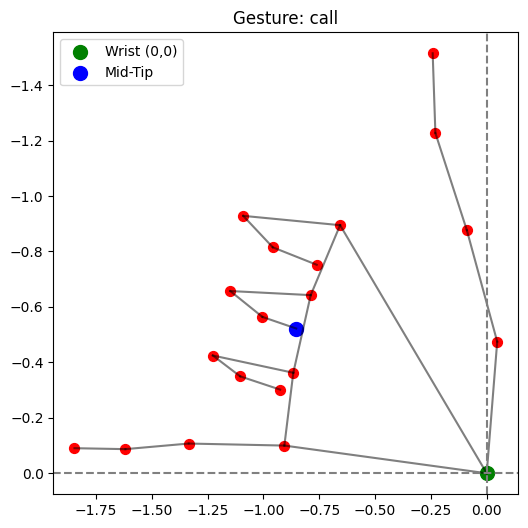

In [14]:
import matplotlib.pyplot as plt
import random

def plot_hand(row_index, data):
    # Extract x and y coordinates for this row
    row = data.iloc[row_index]
    
    x_coords = [row[f'x{i}'] for i in range(21)]
    y_coords = [row[f'y{i}'] for i in range(21)]
    
    # MediaPipe Hand Connections (so we can draw the skeleton lines)
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),         # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),         # Index
        (9, 10), (10, 11), (11, 12),            # Middle
        (13, 14), (14, 15), (15, 16),           # Ring
        (0, 17), (17, 18), (18, 19), (19, 20),  # Pinky
        (5, 9), (9, 13), (13, 17)               # Palm
    ]
    
    plt.figure(figsize=(6, 6))
    
    # Plot connections
    for start, end in connections:
        plt.plot([x_coords[start], x_coords[end]], 
                 [y_coords[start], y_coords[end]], 'k-', alpha=0.5)
        
    # Plot points
    plt.scatter(x_coords, y_coords, c='red', s=50)
    
    # Highlight specific points
    plt.scatter(x_coords[0], y_coords[0], c='green', s=100, label="Wrist (0,0)")  # Wrist
    plt.scatter(x_coords[12], y_coords[12], c='blue', s=100, label="Mid-Tip") # Middle Finger Tip

    plt.title(f"Gesture: {row['label']}")
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.legend()
    
    # Invert Y axis because images usually have (0,0) at top-left, 
    # but normalized graph data might look upside down otherwise.
    plt.gca().invert_yaxis() 
    plt.show()

# --- Run the Plot ---
# Pick a random sample to test
random_idx = random.randint(0, len(data) - 1)
plot_hand(random_idx, data)

Imbalance Ratio (IR) =  1.7492063492063492


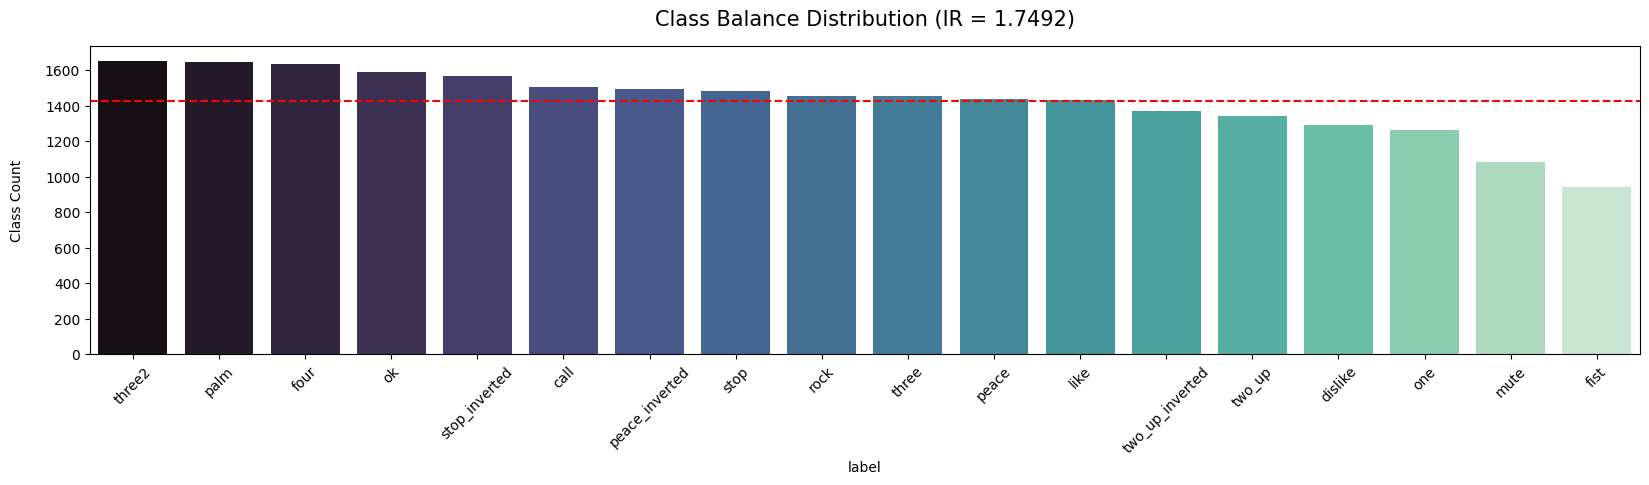

In [15]:
# checking the balance of the dataset classes (Labels)

label_balance = pd.DataFrame({
    'Count': data['label'].value_counts(),
    'Percentage (%)': round(data['label'].value_counts(normalize=True) * 100, 2)}).reset_index().rename(columns={'index': 'label'})
label_balance.sort_values(by ='Count',  ascending= False  , inplace = True)

# as shown here there a small imbalance between the classes , so we need to consider it will training the model 

imbalance_ratio = ( label_balance.iloc[0 , 1] / label_balance.iloc[-1 , 1] )
print('Imbalance Ratio (IR) = ' , imbalance_ratio)

plt.figure(figsize=(20 , 4))
sns.barplot(data=label_balance, y='Count', x='label', hue = 'label', legend=False , palette='mako')

mean_count = label_balance['Count'].mean()
plt.axhline(mean_count, color='red', linestyle='--', label=f'Mean Count ({int(mean_count)})')

plt.title(f'Class Balance Distribution (IR = {imbalance_ratio:.4f})', fontsize=15 , pad = 15)
plt.ylabel('Class Count', fontsize=10 , labelpad= 15)
plt.xticks(rotation=45)
plt.show()


Running t-SNE... this might take a minute.


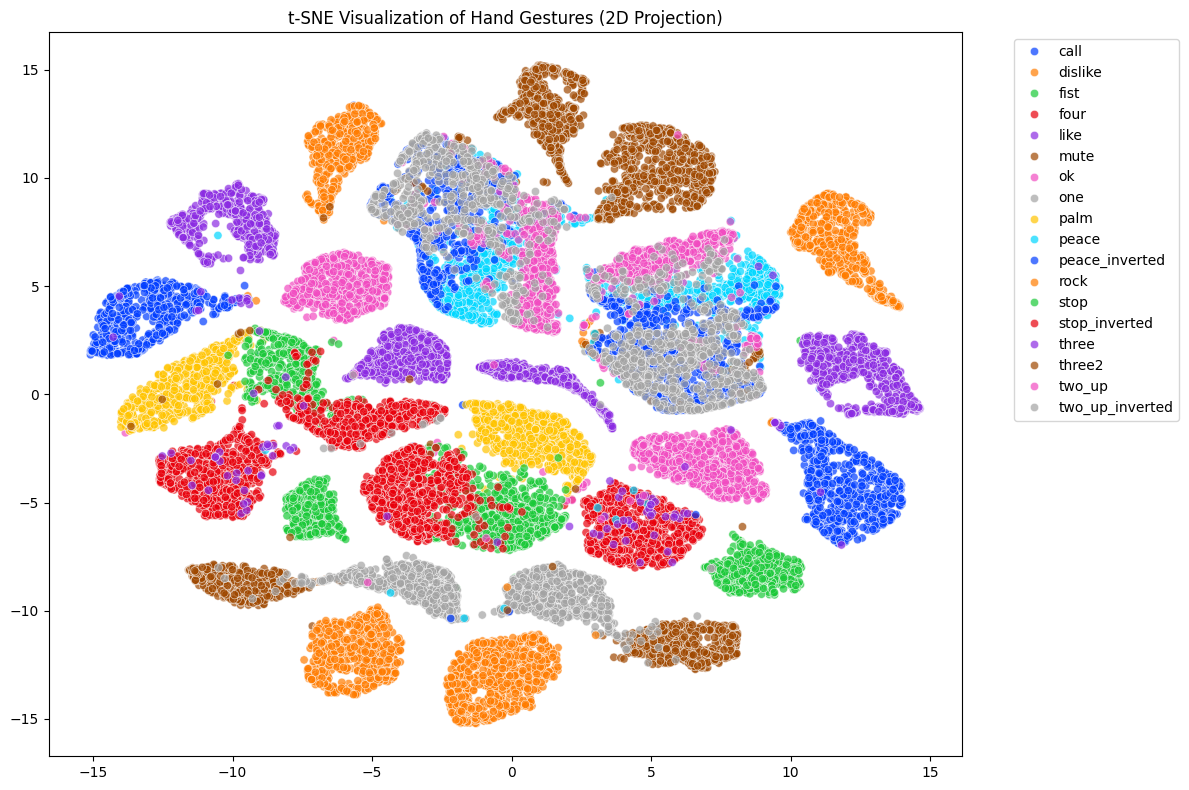

In [16]:
from sklearn.manifold import TSNE

# 2. Select only the numeric features (exclude label)
X_for_tsne = data.drop('label', axis=1)
y_for_tsne = data['label']

# 3. Run t-SNE
print("Running t-SNE... this might take a minute.")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter= 300 ,init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_for_tsne)

# 4. Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=y_for_tsne, 
    palette='bright', 
    legend='full',
    alpha=0.7
)

plt.title('t-SNE Visualization of Hand Gestures (2D Projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

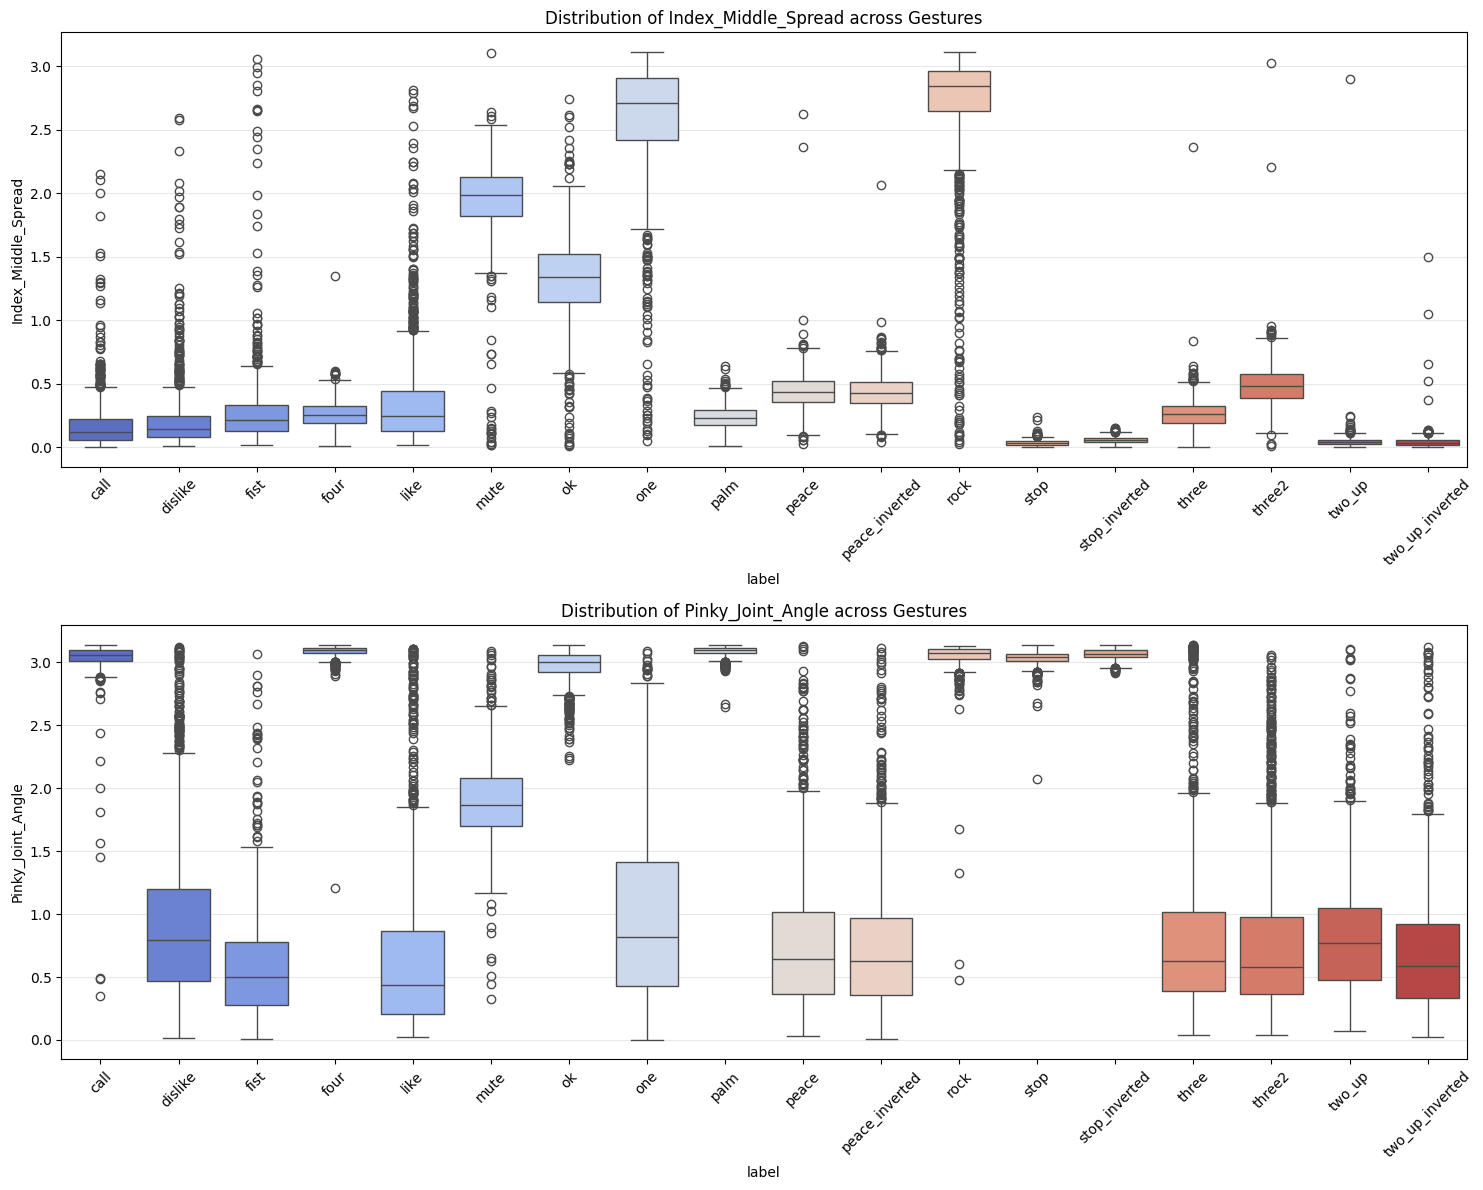

In [17]:
# List of features you want to check (from your feature engineering step)
features_to_check = ['Index_Middle_Spread', 'Pinky_Joint_Angle']

plt.figure(figsize=(15, 6 * len(features_to_check)))

for i, feature in enumerate(features_to_check):
    plt.subplot(len(features_to_check), 1, i+1)
    
    # Boxplot shows the distribution (Median, min, max) of the angle for each gesture
    sns.boxplot(data=data, x='label', y=feature, hue = 'label' ,legend=False, palette='coolwarm')
    
    plt.title(f'Distribution of {feature} across Gestures')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# as shown in the plot , the angles make sense with the classes , like one and rock hav high Index_Middle_Spread and two_up have low Index_Middle_Spread 
# and the Pinky_Joint_Angle are high in the classes that has high Pinky finger use in it  

In [18]:
# spliting the Data to Train(80%) and Test(20%) sets with stratification to maintain the class balance in both sets

features = data.drop(columns=['label'])
labels = data['label']

# using stratify=labels to maintain the balance of each class in the dataset split 
# usong shuffle=True to shuffle the rows , as the rows can be consecutive from a video 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42 , stratify=labels , shuffle=True)

In [19]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', C= 10 , gamma = 0.01, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42)
}


results = []


experiment_name = "Hand_Gesture_Classification"

for name, model in models.items():
    print(f"Training & Logging {name}...")
    
    with mlflow_utils.init_mlflow_experiment(experiment_name, run_name=name):
        

        model.fit(X_train, y_train)
        # Autolog captured it all automatically.


        # for Actual metrics we need to use the test split
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append({"Model": name,"Accuracy": acc,"F1-Score": f1})

        mlflow.log_param("Test_Accuracy", acc)
        mlflow.log_param("Test_F1-Score", f1)
        
    print(f"Finished logging {name}.\n")


# Comparison Table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nFinal Comparison:")
print(results_df)


Training & Logging Random Forest...
Finished logging Random Forest.

Training & Logging SVM...
Finished logging SVM.

Training & Logging Logistic Regression...
Finished logging Logistic Regression.


Final Comparison:
                 Model  Accuracy  F1-Score
0        Random Forest  0.984421  0.984439
2  Logistic Regression  0.975463  0.975487
1                  SVM  0.974489  0.974516


In [ ]:
#Starting with a GridSearch SVM(RBF) Classifier to fine tune the parameters on the data


# pipe = Pipeline([('scaler', RobustScaler()), ('svc', SVC(class_weight='balanced'))])

svc_model = SVC()

experiment_name = "Hand_Gesture_Classification"

param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ['scale', 0.1 , 0.01],
    "svc__kernel": ["rbf"]
}

grid_search = GridSearchCV( svc_model , param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=2)

with mlflow_utils.init_mlflow_experiment(experiment_name, run_name='Fine-Tuning SVM1.2 Model_NoRobScale'):
    
    # Autolog captured it all automatically.

    print("Starting Grid Search... this might take a few minutes.")
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score: {grid_search.best_score_}")

    best_svm_model = grid_search.best_estimator_
    accuracy = best_svm_model.score(X_test, y_test)
    print(f"Test Set Accuracy: {accuracy}")



Starting Grid Search... this might take a few minutes.
Fitting 5 folds for each of 12 candidates, totalling 60 fits


2026/02/16 23:54:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


Best Parameters: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best Cross-Validation Score: 0.9849074975657255
Test Set Accuracy: 0.9859785783836417


In [20]:
y_pred = best_svm_model.predict(X_test)

print("Evaluation Report:")
print(classification_report(y_test, y_pred))

Evaluation Report:
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       0.98      1.00      0.99       189
           four       0.98      0.98      0.98       327
           like       0.99      0.99      0.99       287
           mute       0.96      0.96      0.96       217
             ok       1.00      0.99      0.99       318
            one       0.96      0.97      0.96       253
           palm       0.98      0.99      0.99       330
          peace       1.00      0.97      0.98       288
 peace_inverted       0.99      0.99      0.99       299
           rock       0.99      1.00      0.99       292
           stop       0.97      0.98      0.97       296
  stop_inverted       0.98      0.99      0.99       314
          three       0.99      0.97      0.98       291
         three2       0.99      0.99      0.99       331
         tw

In [21]:
# Save the best model (SVM) to a pickle file
joblib.dump(best_svm_model, "models\SVM1_RawZ_RobScale.pkl")

print("Model saved successfully as 'SVM1_RawZ_RobScale.pkl'!")

Model saved successfully as 'SVM1_RawZ_RobScale.pkl'!
